In [1]:
import numpy as np
import imf
import random
import matplotlib.pyplot as plt
from scipy.integrate import quad

### m1: mass of primary star
First, we draw the mass of the primary star $\left(m_{\mathrm{A}}\right)$ of the system using a initial mass function (IMF), following https://github.com/keflavich/imf

In [6]:
# mass primary star
m1 = imf.make_cluster(100000, massfunc='chabrier', mmin=0.1, mmax=1.5)[:100000]
m1 = np.sort(m1)
num_m = len(np.where(m1 < 0.5)[0])
num_fgk = 100000-num_m

Total cluster mass is 100000 (limit was 100000)


### oribital_period (unit: days)
$$
\xi\left(\log P_b\right) \propto \exp \left\{-\left(\log P_b-\log \overline{P_b}\right)^2 / 2 \sigma_{\log P_b}^2\right\}
$$
- $\overline{\log P_b}=3.69$ and $\sigma_{\log P_b}=1.3$ for M-type primary stars
- $\overline{\log P_b}=5.03$ and $\sigma_{\log P_b}=2.28$ for FGK type primary stars. 
- We use $m_{\ell}=0.5 \mathrm{M}_{\odot}$ as a threshold value between M-type stars and stars of earlier type.  
- In both cases we limit our draws in the [0,5] $\log P_b$ interval for close binary

Changes: instead of doing np.clip for [0,10], we generate a larger sample and cut it following the ratio of m dwarfs and fgk stars in primary mass function

In [7]:
# period
log_mean_m = 3.69
log_std_m = 1.3
log_mean_fgk = 5.03
log_std_fgk = 2.28
log_p_m = np.random.normal(loc=log_mean_m, scale=log_std_m, size=200000)
log_p_fgk = np.random.normal(loc=log_mean_fgk, scale=log_std_fgk, size=200000)
log_p_m = log_p_m[np.where((log_p_m < 4.5) & (log_p_m > 0))]
log_p_fgk = log_p_fgk[np.where((log_p_fgk < 4.5) & (log_p_fgk > 0))]
log_p = np.concatenate((log_p_m[0:num_m],log_p_fgk[0:num_fgk]))
period = 10**log_p

In [8]:
np.mean(log_p)

3.0836450815401744

In [9]:
np.mean(period)

5370.972605031261

### mass_ratio

In [10]:
mu = np.random.uniform(0.2, 0.5, 100000)

In [11]:
m2 = (mu * m1) / (1 - mu)
q_mass = m2/m1

### Binary semi-major axis & mutural gravitational attraction (P)

Given the masses of the two stars in a binary system, their semi-major axis (a), and eccentricity (e), you can calculate the period of their mutual gravitational attraction (P) using Kepler's third law:

P^2 = 4π^2 a^3 / G (m1 + m2)

where G is the gravitational constant, m1 and m2 are the masses of the stars, and a is the semi-major axis of their orbit.

http://spiff.rit.edu/classes/phys440/lectures/kepler3/kepler3.html


In [13]:
# semimajor axis
G = 6.6743e-11   # gravitational constant in m^3 kg^-1 s^-2
solar_mass = 1.98847e30   # mass of the Sun in kg
M_total = solar_mass * (m1 + m2)   # total mass in kg
p_sec = period * 86400   # orbital period in seconds
au = 1.496e11
ab = ((G * M_total * p_sec**2) / (4 * np.pi**2))**(1/3)   # semi-major axis in meters
ab = ab/au

### binary_eccentricity

We finally assign the orbital eccentricity, $e_b$, using another empirical distribution, $\xi\left(e_b\right)$. The eccentricity distribution is strongly affected by the orbital period: for $P_b$ less than a certain value identified as the circularization period $P_{\text {circ }}$ the orbits are circularized due to the long-term history of tidal interactions between the two stars. On the other hand, the eccentricity distribution shows a remarkably small dependence on the mass of the primary. For our calculation, we build a Gaussian distribution with $P_{\text {circ }}=20$ days $\left(\log P_b=1.3\right)$, the function will have the form:
$$
\xi\left(e_b\right) \propto \exp \left[-\left(e_b-\bar{e}\right)^2 / 2 \sigma_e^2\right]
$$
$\bar{e}=0.35$ and $\sigma_e=0.2$ for all values of $P_b$ above 20 days. 


In [14]:
def generate_eccentricity(logPb):
    sigma_e = 0.2
    mean_e = 0.35
    P_circ = 1.3
    ecc = np.random.normal(loc=mean_e, scale=sigma_e, size=len(logPb))
    ecc[ecc < 0] = 0
    ecc[ecc > 0.8] = 0
    ecc[logPb < P_circ] = 0
    return ecc

e = generate_eccentricity(log_p)

### Effective Temperature & Luminocity

In [16]:
# unit: solar radius / Kelvin / solar luminosity
# Stephan–Boltzmann relation
R1 = m1**0.8
R2 = m2**0.8
T1 = (m1**0.505)*5780
T2 = (m2**0.505)*5780
L1 = (R1**2)*((T1/5780)**4)
L2 = (R2**2)*((T2/5780)**4)

### Boundaries of dynamical stability
​
The parameters $m_{\mathrm{A}}, \mu=m_{\mathrm{B}} /\left(m_{\mathrm{A}}+m_{\mathrm{B}}\right), a_b$, and $e_b$, drawn for each binary systems are used to explore which regions of parameter space are consistent with the existence of stable planetary orbits. These authors derived empirical expressions for calculating the  **smallest circumbinary orbit** where fully-interacting particles survive the length of the integration ($10^5$ binary periods). The semi-major axis of such critical planetary orbits are approximated as functions of $e_b$ and $\mu$. 
​
In units of the binary semi-major axis, the semi-major axis of the smallest, stable P-type orbit is:
$$
a_p =(p + q* e_b - r * e_b^2 + s * \mu+t * e_b \mu - u * \mu^2 - v * e_b^2 \mu^2) * {a_b}
$$
​


In [17]:
p = 1.6
q = 5.1
r = -2.22
s = 4.12
t = -4.27
u = -5.09
v = 4.61
ap = (p + q*e + r*(e**2) + s*mu + t*e*mu + u*(mu**2) + v*(e**2)*(mu**2))*ab

In [19]:
import pandas as pd
# Create data frame
data = {'m1':m1, 'm2':m2, 'r1':R1, 'r2':R2, 'p':period, 'logP': log_p,'q': q_mass, 'mu':mu, \
        'e': e, 'ab': ab, 'L1': L1,'t1':T1, 'L2':L2, 't2':T2,'ap':ap}
# Create pandas DataFrame
df = pd.DataFrame(data)
# Print DataFrame
print(df.tail())

             m1        m2        r1        r2             p      logP  \
99995  1.499143  0.744782  1.382529  0.789993    968.399305  2.986054   
99996  1.499151  0.775478  1.382535  0.815935  13209.871109  4.120899   
99997  1.499396  0.900128  1.382716  0.919271   5180.128435  3.714341   
99998  1.499426  1.403142  1.382739  1.311237  15081.272956  4.178438   
99999  1.499546  0.545621  1.382827  0.615904   2182.506958  3.338956   

              q        mu         e         ab        L1           t1  \
99995  0.496805  0.331910  0.427949   2.507870  4.330635  7091.343712   
99996  0.517278  0.340925  0.139637  14.382524  4.330717  7091.362529   
99997  0.600327  0.375128  0.358291   7.843947  4.333283  7091.948629   
99998  0.935786  0.483414  0.356073  17.040620  4.333602  7092.021452   
99999  0.363858  0.266786  0.000000   4.179708  4.334849  7092.306051   

             L2           t2         ap  
99995  0.344148  4980.838483   9.201869  
99996  0.398328  5083.471203  41.55161

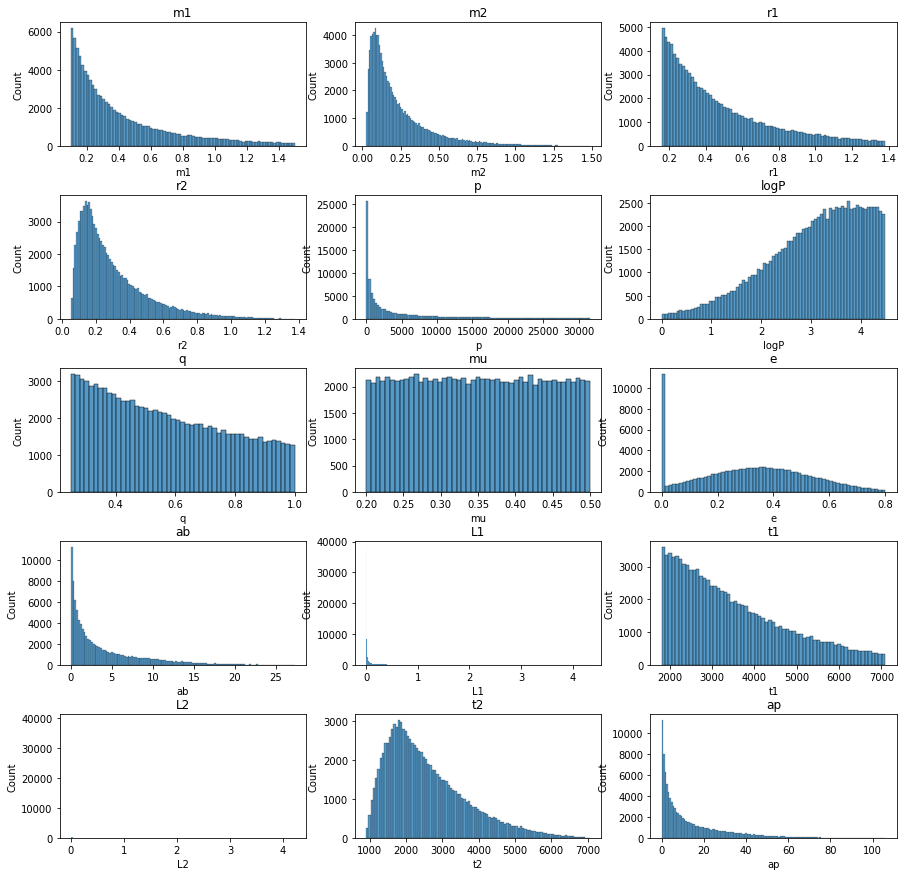

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure with subplots
fig, axs = plt.subplots(nrows=5, ncols=3, figsize=(15, 15))
fig.subplots_adjust(hspace=0.4)

# Plot histograms for each column
sns.histplot(df['m1'], ax=axs[0,0])
sns.histplot(df['m2'], ax=axs[0,1])
sns.histplot(df['r1'], ax=axs[0,2])
sns.histplot(df['r2'], ax=axs[1,0])
sns.histplot(df['p'], ax=axs[1,1])
sns.histplot(df['logP'], ax=axs[1,2])
sns.histplot(df['q'], ax=axs[2,0])
sns.histplot(df['mu'], ax=axs[2,1])
sns.histplot(df['e'], ax=axs[2,2])
sns.histplot(df['ab'], ax=axs[3,0])
sns.histplot(df['L1'], ax=axs[3,1])
sns.histplot(df['t1'], ax=axs[3,2])
sns.histplot(df['L2'], ax=axs[4,0])
sns.histplot(df['t2'], ax=axs[4,1])
sns.histplot(df['ap'], ax=axs[4,2])

# Set titles for each subplot
axs[0,0].set_title('m1')
axs[0,1].set_title('m2')
axs[0,2].set_title('r1')
axs[1,0].set_title('r2')
axs[1,1].set_title('p')
axs[1,2].set_title('logP')
axs[2,0].set_title('q')
axs[2,1].set_title('mu')
axs[2,2].set_title('e')
axs[3,0].set_title('ab')
axs[3,1].set_title('L1')
axs[3,2].set_title('t1')
axs[4,0].set_title('L2')
axs[4,1].set_title('t2')
axs[4,2].set_title('ap')

# Show the plot
plt.show()


### Boundaries of insolation
Parameters:
- $L_i$ is the luminosity of each of the two stars $(i=1,2)$ 
- $r_{\mathrm{p}-i}$ the distance between the planet and each star. 
- $w\left(T_i, \mathcal{R}\right)$ is a spectral weight dependent on the effective temperature of each star, $T_i$, and on a set of atmospheric parameters, 
- $\mathcal{R}_x$, that specify the radiative properties of the planetary atmosphere (e.g. clouds, atmospheric composition, stratification, surface pressure, etc.).

To define the insolation boundaries in a binary system, we calculate at which distance from the stars, $r_{\mathrm{p}-1}$ and $r_{\mathrm{p}-2}$, the effective flux 15 matches the flux received by a planet at the inner and outer edge $(\mathrm{x}=\mathrm{in}$, out) of the classic HZ around a single star. 

In practice, we impose the condition: $F_{\text {eff, } \mathrm{x}}=L_{\mathrm{Sun}} / l_{\mathrm{x} \text {-Sun }}^2$, where $l_{\mathrm{x} \text {-Sun }}$ is the inner or outer edge of the HZ around the Sun. 

We use the equation $w\left(T_i, \mathcal{R}_{\mathrm{x}}\right)=\left[1+\alpha_{\mathrm{x}}\left(T_i, \mathcal{R}_{\mathrm{x}}\right) l_{\mathrm{x}-\mathrm{Sun}}^2\right]^{-1}$, where $$
\alpha_{\mathrm{x}}\left(T_i, \mathcal{R}_{\mathrm{x}}\right)=\mathrm{a}_{\mathrm{x}} \tilde{T}_i+\mathrm{b}_{\mathrm{x}} \tilde{T}_i^2+\mathrm{c}_{\mathrm{x}} \tilde{T}_i^3+\mathrm{d}_{\mathrm{x}} \tilde{T}_i^4
$$
with $\tilde{T}_i=T_i-5780 \mathrm{~K}$

### Flux limits and coefficients 

Fluxes are in units of the mean orbital Earth insolation

$$
\begin{array}{lcc}
\hline \begin{array}{l}
\text { Constant } \\
\text { value }
\end{array} & \begin{array}{c}
\text { Runaway } \\
\text { Greenhouse }
\end{array} & \begin{array}{c}
\text { Maximum } \\
\text { Greenhouse }
\end{array} \\
\hline F_{\mathrm{x}}\left(\mathrm{S}_{\oplus}\right) & 1.0385 & 0.3507 \\
l_{\mathrm{x} \text {-Sun }}(\mathrm{AU}) & 0.9813 & 1.6882 \\
\mathrm{a}_{\mathrm{x}} & 1.2456 \times 10^{-4} & 5.9578 \times 10^{-5} \\
\mathrm{~b}_{\mathrm{x}} & 1.4612 \times 10^{-8} & 1.6707 \times 10^{-9} \\
\mathrm{c}_{\mathrm{x}} & -7.6345 \times 10^{-12} & -3.0058 \times 10^{-12} \\
\mathrm{~d}_{\mathrm{x}} & -1.7511 \times 10^{-15} & -5.1925 \times 10^{-16} \\
\hline
\end{array}
$$

In [20]:
def alpha_x(T_i, R_x, a_x, b_x, c_x, d_x):
    tilde_T_i = T_i - 5780
    return a_x * tilde_T_i + b_x * tilde_T_i**2 + c_x * tilde_T_i**3 + d_x * tilde_T_i**4

def w(T_i, R_x, a_x, b_x, c_x, d_x, l_x_Sun):
    alpha_x_value = alpha_x(T_i, R_x, a_x, b_x, c_x, d_x)
    return 1 / (1 + alpha_x_value * l_x_Sun**2)

In [22]:
# Store the arrays as separate variables
Fx = [1.0385, 0.3507]
lx = [0.9813, 1.6882]
ax = [1.2456e-4, 5.9578e-5]
bx = [1.4612e-8, 1.6707e-9]
cx = [-7.6345e-12, -3.0058e-12]
dx = [-1.7511e-15, -5.1925e-16]